In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
shap_rf = load("dumped_shap/shap_rf_kernel.joblib")
shap_rf_tree = load("dumped_shap/shap_rf_tree.joblib")

shap_dnn = load("dumped_shap/shap_dnn_kernel.joblib")
shap_dnn_deep = load("dumped_shap/shap_dnn_deep.joblib")
shap_dnn_grad = load("dumped_shap/shap_dnn_grad.joblib")

In [76]:
def cosim2(a, b=[1,0,0,0,0]):
    return np.dot(a, b)/(np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))

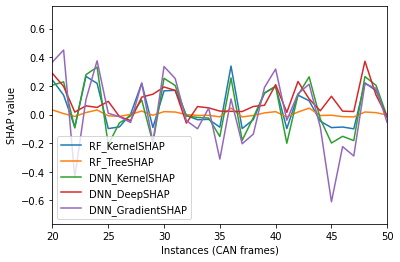

In [78]:
import matplotlib.pyplot as plt

rf_kernel = pd.Series([cosim2(x) for x in shap_rf.values])
rf_tree = pd.Series([cosim2(x) for x in shap_rf_tree.values])
dnn_kernel = pd.Series([cosim2(x) for x in shap_dnn.values])
dnn_deep = pd.Series([cosim2(x) for x in shap_dnn_deep.values])
dnn_grad = pd.Series([cosim2(x) for x in shap_dnn_grad.values])

idx = rf_kernel.sort_index().index

plt.plot(rf_kernel.loc[idx].values, label="RF_KernelSHAP")
plt.plot(rf_tree.loc[idx].values, label="RF_TreeSHAP")
plt.plot(dnn_kernel.loc[idx].values, label="DNN_KernelSHAP")
plt.plot(dnn_deep.loc[idx].values, label="DNN_DeepSHAP")
plt.plot(dnn_grad.loc[idx].values, label="DNN_GradientSHAP")
plt.xlim((20, 50))
plt.xlabel("Instances (CAN frames)")
plt.ylabel("SHAP value")
plt.legend()
plt.savefig("../images/SHAP/final/shap_comparison_diff.pdf", dpi=300, bbox_inches="tight")

In [4]:
df: pd.DataFrame = load("dumped_datasets/survival_all.joblib")
# df: pd.DataFrame = load("dumped_datasets/road_all.joblib")
# df: pd.DataFrame = load("dumped_datasets/hisingen_all.joblib")

df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

# display(df)

In [5]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [36]:
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# X_test, y_test = rus.fit_resample(X_test, y_test)
# bintr = np.bincount(y_train)
# binte = np.bincount(y_test)
# print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

In [6]:
name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [7]:
from pp_tools import scale_dataset

X_train_original = X_train.copy()
X_test_original = X_test.copy()

X_combined = pd.concat([X_train, X_test])

scale_dataset(X_combined)

test_len = len(X_test)
X_test = X_combined.iloc[-test_len:]
X_train = X_combined.iloc[:-test_len]

X_combined = None # Release memory

vvv RF vvv

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
rf.fit(X_train.values, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

vvv DNN vvv

In [8]:
import tensorflow as tf
# import tensorflow.keras as keras
import keras

dnn = keras.models.load_model("dnn_all_survival_imbalanced")

vvv SHAP vvv

In [9]:
import shap

X_sample = pd.concat([X_train[y_train == 1].sample(50, random_state=0), X_train[y_train == 0].sample(50, random_state=0)]).values

# vvv RF vvv

# exp_rf = shap.KernelExplainer(rf.predict_proba, data=X_sample, algorithm="kernel")
# exp_rf_tree = shap.TreeExplainer(rf)

# vvv DNN vvv

# exp_dnn = shap.KernelExplainer(dnn.predict, data=X_sample, algorithm="kernel")
# tf.compat.v1.disable_v2_behavior()
# exp_dnn_deep = shap.DeepExplainer((dnn.layers[0].input, dnn.layers[-1].output), data=X_sample)
# exp_dnn_grad = shap.GradientExplainer(dnn, data=X_sample)

# print(exp_rf.expected_value[-1])
# print(exp_rf_tree.expected_value[-1])
# print(exp_dnn.expected_value[-1])
# print(exp_dnn_deep.expected_value[-1])

In [10]:
from shap_tools import *

max_samples = int(min(len(X_train), 600) / 2)

X_exp = pd.concat([X_train[y_train == 1].sample(max_samples, random_state=0), X_train[y_train == 0].sample(max_samples, random_state=0)])
# X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]
X_exp_name = name_train.loc[X_exp.index]

In [43]:
def get_explanation2(explainer, df: pd.DataFrame):
    return shap.Explanation(
        values=explainer.shap_values(df.values)[-1],
        base_values=0.5, # explainer.expected_value[-1],
        data=df.to_numpy(),
        feature_names=df.columns)

In [44]:
# shap_rf = get_explanation2(exp_rf, X_exp)
# shap_rf_tree = get_explanation2(exp_rf_tree, X_exp)

# shap_dnn = get_explanation2(exp_dnn, X_exp)
# shap_dnn_deep = get_explanation2(exp_dnn_deep, X_exp)
# shap_dnn_grad = get_explanation2(exp_dnn_grad, X_exp)

# dump(shap_rf, "dumped_shap/shap_rf_kernel.joblib")
# dump(shap_rf_tree, "dumped_shap/shap_rf_tree.joblib")
# dump(shap_dnn, "dumped_shap/shap_dnn_kernel.joblib")
# dump(shap_dnn_deep, "dumped_shap/shap_dnn_deep.joblib")
# dump(shap_dnn_grad, "dumped_shap/shap_dnn_grad.joblib")

100%|██████████| 600/600 [00:20<00:00, 28.98it/s]


['dumped_shap/shap_rf_tree.joblib']

In [ ]:
display(X_exp)

In [29]:
def plot_beeswarm2(exp_obj):
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="plasma"), label="Feature value")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Low", "High"])
    plt.xlim((-0.5, 0.5))
    vis = shap.plots.beeswarm(exp_obj, max_display=20, color=plt.get_cmap("plasma"), color_bar=False,
        order=[3, 1, 4, 0, 2])

In [11]:
def reform_explanation(exp_obj: shap.Explanation, mask):
    values = exp_obj.values[mask]
    base_value = exp_obj.base_values
    data = exp_obj.data[mask]
    feature_names = exp_obj.feature_names
    return shap.Explanation(
        values=values,
        base_values=base_value,
        data=data,
        feature_names=feature_names)

In [ ]:
display(X_exp_name)

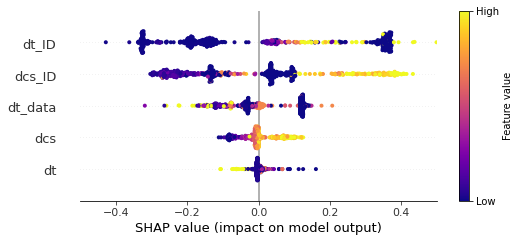

In [32]:
# plot_beeswarm2(shap_rf)
# plot_beeswarm2(shap_rf_tree)
# plot_beeswarm2(shap_dnn)
# X_exp_r = X_exp.reset_index(drop=True)
# X_exp_name_r = X_exp_name.reset_index(drop=True)
# plot_beeswarm2(reform_explanation(shap_dnn, (X_exp_name_r == "Malfunction_dataset_SONATA")))
# plot_beeswarm2(reform_explanation(shap_dnn, (X_exp_name_r == "Fuzzy_dataset_SONATA")))
# plot_beeswarm2(shap_dnn_deep)
plot_beeswarm2(shap_dnn)

In [ ]:
# shap.summary_plot(shap_rf, plot_type="bar")
# shap.summary_plot(shap_rf_tree, plot_type="bar")
# shap.summary_plot(shap_dnn, plot_type="bar")
# shap.summary_plot(shap_dnn_deep, plot_type="bar")
# shap.summary_plot(shap_dnn_grad, plot_type="bar")

tata = pd.DataFrame([shap_rf, shap_rf_tree, shap_dnn, shap_dnn_deep, shap_dnn_grad])

# sns.barplot()

,RF_KernelSHAP,RF_TreeSHAP,DNN_KernelSHAP,DNN_DeepSHAP
RF_TreeSHAP,0.921925,1.000000,0.896580,0.859763
DNN_KernelSHAP,0.848451,0.896580,1.000000,0.941709
DNN_DeepSHAP,0.808721,0.859763,0.941709,1.000000
DNN_GradientSHAP,0.719829,0.743456,0.834339,0.811054


,RF_KernelSHAP,RF_TreeSHAP,DNN_KernelSHAP,DNN_DeepSHAP
RF_TreeSHAP,0.922\n(0.131),1.000\n(0.000),0.897\n(0.096),0.860\n(0.122)
DNN_KernelSHAP,0.848\n(0.145),0.897\n(0.096),1.000\n(0.000),0.942\n(0.071)
DNN_DeepSHAP,0.809\n(0.140),0.860\n(0.122),0.942\n(0.071),1.000\n(0.000)
DNN_GradientSHAP,0.720\n(0.236),0.743\n(0.258),0.834\n(0.251),0.811\n(0.303)


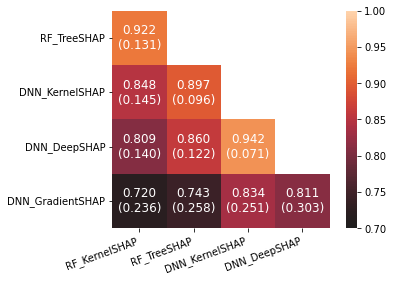

In [79]:
import seaborn as sns

def euclid(a, b):
    return np.sqrt(np.dot(b-a, b-a))

def cosim(a, b):
    return np.dot(a, b)/(np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))

# shap_rf_avg = np.array(shap_rf.values).flatten() # np.mean(shap_rf.values, axis=0)
# shap_dnn_avg = np.array(shap_dnn.values).flatten() # np.mean(shap_dnn.values, axis=0)

# print(shap_rf_avg)
# print(shap_dnn_avg)

# shap_cosims = np.sort(list(map(cosim, shap_rf.values, shap_rf_tree.values)))
# shap_cosims = list(map(cosim, shap_rf.values, shap_rf_tree.values))

all_shaps = [shap_rf, shap_rf_tree, shap_dnn, shap_dnn_deep, shap_dnn_grad]
names = ["RF_KernelSHAP", "RF_TreeSHAP", "DNN_KernelSHAP", "DNN_DeepSHAP", "DNN_GradientSHAP"]

temp = pd.DataFrame(index=names, columns=names, dtype=np.float64)
annots = pd.DataFrame(index=names, columns=names, dtype=str)
for i in range(5):
    for j in range(5):
        temp.iloc[i, j] = np.mean(list(map(cosim, all_shaps[i].values, all_shaps[j].values)))
        annots.iloc[i, j] = str(format(np.mean(list(map(cosim, all_shaps[i].values, all_shaps[j].values))), ".3f"))
        annots.iloc[i, j] += "\n(" + str(format(np.std(list(map(cosim, all_shaps[i].values, all_shaps[j].values))), ".3f")) + ")"

# Drop first row and last column that don't provide information
temp.drop(index=temp.index[0], inplace=True)
temp.drop(columns=temp.columns[-1], inplace=True)
annots.drop(index=annots.index[0], inplace=True)
annots.drop(columns=annots.columns[-1], inplace=True)

# Generate a mask for the upper triangle but not the diagonal
mask = np.triu(np.ones_like(temp, dtype=bool))
np.fill_diagonal(mask, False)

display(temp)
display(annots)




sns.heatmap(temp, annot=annots, square=True, mask=mask, vmin=0.7, vmax=1, center=0.7, annot_kws={"fontsize": 12}, fmt="s")
plt.xticks(rotation=20, horizontalalignment="right")

plt.savefig("../images/SHAP/final/shap_comparison_new.pdf", dpi=300, bbox_inches="tight")

# print(np.mean(shap_cosims))
# print(euclid(shap_rf_avg, shap_dnn_avg))
# plt.plot(shap_cosims)

In [19]:
import matplotlib
from matplotlib.patches import Rectangle
def cust_exp(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, scale):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = (df_exp[feature] >= scale[0]) & (df_exp[feature] < scale[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask].copy()
    
    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values # [0]

    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    df_exp["shap_hues"] = shap_hues
    
    normal_values = df_exp.loc[df_exp["Label"] == "normal", [feature, "shap_hues"]]
    attack_values = df_exp.loc[df_exp["Label"] == "attack", [feature, "shap_hues"]]
    
    normal_hist, normal_bins = np.histogram(normal_values[feature], bins=50, range=(scale[0], scale[1]))
    attack_hist, attack_bins = np.histogram(attack_values[feature], bins=50, range=(scale[0], scale[1]))

    fig, ax = plt.subplots(dpi=100, figsize=(10, 1))
    
    max_bar = max(normal_hist.max(), attack_hist.max())
    normal_hist = normal_hist / max_bar
    attack_hist = attack_hist / max_bar

    # normal_cont = ax.bar(normal_bins[:-1], normal_hist, width=(scale[1] - scale[0])/50, align="edge")
    # attack_cont = ax.bar(attack_bins[:-1], -attack_hist, width=(scale[1] - scale[0])/50, align="edge")

    normal_cont = ax.bar(normal_bins[:-1], np.tanh(normal_hist*1.0)+0.04, width=(scale[1] - scale[0])/50, align="edge")
    attack_cont = ax.bar(attack_bins[:-1], np.tanh(-attack_hist*1.0)-0.04, width=(scale[1] - scale[0])/50, align="edge")


    # Colorize and shift
    prev_edge = 0
    for i in range(1, len(normal_bins)):
        normal_hues_mean = normal_values.loc[(normal_values[feature] >= normal_bins[prev_edge]) & (normal_values[feature] < normal_bins[i]), "shap_hues"].fillna(0.5).mean()
        attack_hues_mean = attack_values.loc[(attack_values[feature] >= attack_bins[prev_edge]) & (attack_values[feature] < attack_bins[i]), "shap_hues"].fillna(0.5).mean()

        normal_cont.patches[i - 1].set_facecolor(cmap(normal_hues_mean))
        attack_cont.patches[i - 1].set_facecolor(cmap(attack_hues_mean))
        
        normal_cont.patches[i - 1].set_y(0.02)
        attack_cont.patches[i - 1].set_y(-0.02)

        prev_edge = i

    ticks = np.linspace(scale[0], scale[1], 11)
    tick_unit = ticks[1]
    ax.set_xlim(scale[0]-0.3*tick_unit, scale[1]+0.3*tick_unit)
    ax.set_xticks(ticks=ticks) #, labels=map(lambda x: format(x, '.2f'), np.linspace(0, 0.02, 11)))
    ax.set_ylim(-1, 1)
    ax.set_yticks(ticks=[-0.5, 0.5], labels=["attack", "normal"])

    # ax.axhline(y=0, color="black", linewidth=1, zorder=-1)
    ax.add_artist(Rectangle((scale[0]-tick_unit*0.2, -0.02), width=scale[1]+tick_unit*0.4, height=0.04, color="black", linewidth=0))

    plt.show()

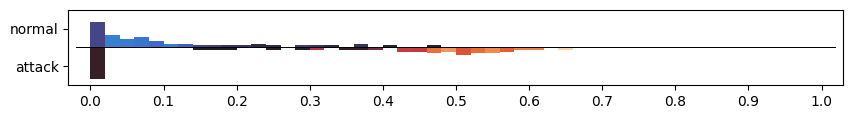

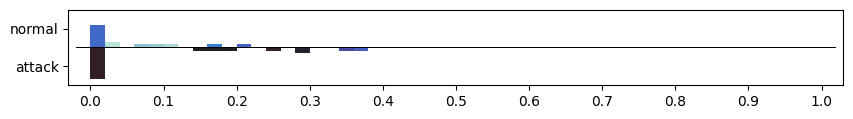

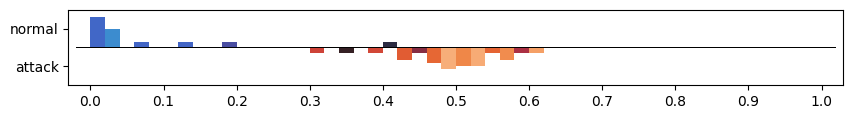

In [20]:
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", scale=(0, 0.0003))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_dnn, "dcs_ID", scale=(0, 1))
mask = (X_exp_name == "Malfunction_dataset_SONATA")
cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 1))
mask = (X_exp_name == "Fuzzy_dataset_SONATA")
cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 1))
# cust_exp(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
#     reform_explanation(shap_dnn, mask), "dcs_ID", scale=(0, 0.6))
# cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", scale=(0, 0.02))

In [17]:
import matplotlib
from matplotlib.patches import Rectangle
def plot_test(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, trim, y_squish=10, scale=1, colorbar=False, y_size=1, more=""):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    # vvv Masking outliers vvv

    mask = (df_exp[feature] >= trim[0]) & (df_exp[feature] < trim[1])
    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask]

    # ^^^ Masking outlier ^^^

    fig, ax = plt.subplots(dpi=100, figsize=(80, y_squish))
    
    cmap_name = "icefire"
    violin_color = "lightgray"

    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values
    
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    values = df_exp[feature]
    # feature_min = values.min()
    # feature_max = values.max()
    # values = (values - values.min()) / (values.max() - values.min())
    label = df_exp["Label"]

    sns.swarmplot(x=values, y=label, order=["normal", "attack"],
        hue=shap_hues, orient="h", palette=palette,
        size=5)
    
    # Change offset on dots for normal (0)
    offsets = ax.collections[0].get_offsets()
    offsets = [[elem[0], -abs(elem[1] - 0) - 0.05] for elem in offsets]
    ax.collections[0].set_offsets(offsets)

    # Change offset on dots for attack (1)
    offsets = ax.collections[1].get_offsets()
    offsets = [[elem[0], abs(elem[1] - 1) + 0.05] for elem in offsets]
    ax.collections[1].set_offsets(offsets)

    fig.set_size_inches(10, y_size)

    sns.violinplot(x=values, y=[0]*label.size, hue=label, split=True, hue_order=["normal", "attack"],
        orient="h",  showfliers=False, scale="count", bw=0.2, gridsize=1000, linewidth=0, color=violin_color,
        cut=0, inner=None)
    
    ax.legend_.remove()
    
    for violin in ax.findobj(matplotlib.collections.PolyCollection):
        violin.set_facecolor("lightgray")
    

    if colorbar:
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_name), location="bottom", shrink=0.4, anchor=(0.10, 0), pad=0.4)
        cbar.set_label("contribution", labelpad=-55)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(["towards\nnormal", "none", "towards\nattack"])

        # plt.arrow(0, 0.5, 1, 0, facecolor="black",
        #     width=0.07, head_length=0.7, head_width=0.2,
        #     length_includes_head=True)

    # f_dict = {"dcs": "A", "dcs_ID": "A", "dt": "C", "dt_ID": "B", "dt_data": "E"}
    # feature = f_dict[feature]
    # ax.set_title(f"How the RF-model classifies data - feature: {feature}")
    # ax.set_title(feature)
    # feature = feature + " (ms)" if feature[0:2] == "dt" else feature
    
    ticks = np.linspace(trim[0], trim[1], 11)

    # vvv ARROWS vvv

    if attack_outliers.size != 0:
        attack_outliers /= max(abs(attack_outliers.min()), abs(attack_outliers.max()))
        attack_outliers = (attack_outliers + 1) * shap_all.base_values

    if normal_outliers.size != 0:
        normal_outliers /= max(abs(normal_outliers.min()), abs(normal_outliers.max()))
        normal_outliers = (normal_outliers + 1) * shap_all.base_values

    s_last = ax.get_xticks()[-2]
    last = ax.get_xticks()[-1]
    
    largest_outliers = max(len(normal_outliers), len(attack_outliers))

    if normal_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, -0.28, f"{len(normal_outliers)}")
        arrow_length = 0.5 * ticks[1] * (len(normal_outliers) / largest_outliers)
        ax.arrow(ticks[-1]+ticks[1]*0.3, -0.25, arrow_length, 0,
            facecolor=cmap(normal_outliers.mean()), linewidth=0,
            width=0.09, head_length=(arrow_length)*0.7, head_width=0.3,
            length_includes_head=True)
    if attack_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, 0.22, f"{len(attack_outliers)}")
        arrow_length = 0.5 * ticks[1] * (len(attack_outliers) / largest_outliers)
        ax.arrow(ticks[-1]+ticks[1]*0.3, 0.25, arrow_length, 0,
            facecolor=cmap(attack_outliers.mean()), linewidth=0,
            width=0.09, head_length=(arrow_length)*0.7, head_width=0.3,
            length_includes_head=True)
    
    # ^^^ ARROWS ^^^

    ax.set_xlabel("")
    ax.set_ylabel(feature) #, rotation="vertical", x=-1, y=0.4)
    ax.set_xticks(ticks=ticks)
    ax.set_yticks(ticks=[-0.25, 0.25], labels=["normal", "attack"])
    if normal_outliers.size != 0 or attack_outliers.size != 0:
        ax.set_xlim((trim[0]-ticks[1]*0.3, trim[1]+ticks[1]))
    else:
        ax.set_xlim((trim[0]-ticks[1]*0.3, trim[1]+ticks[1]*0.3))

    ax.add_artist(Rectangle((trim[0]-ticks[1]*0.2, -0.01), width=trim[1]+ticks[1]*0.4, height=0.02, color="black", linewidth=0))
    # ax.axhline(y=0, color="black", linewidth=0.5)
    ax.margins(x=0.5)
    
    plt.savefig(f"../images/custom_exp/dnn_survival_custom_{feature+more}_comp.pdf", dpi=300, bbox_inches="tight")
    plt.show()

14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


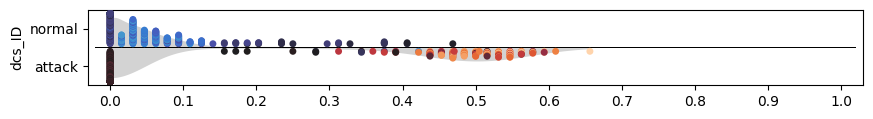

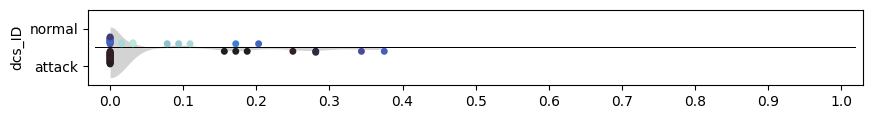

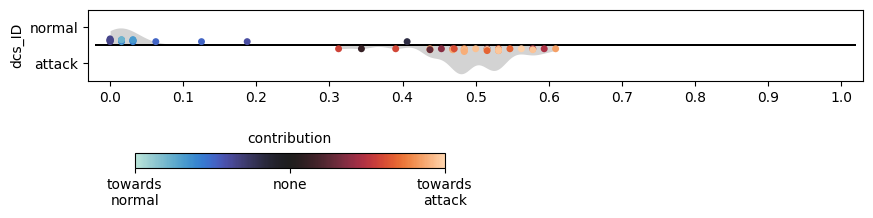

In [18]:
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_dnn, "dcs_ID", trim=(0, 1), y_squish=15)
mask = (X_exp_name == "Malfunction_dataset_SONATA")
plot_test(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", trim=(0, 1), y_squish=15, more="mal")
mask = (X_exp_name == "Fuzzy_dataset_SONATA")
plot_test(pd.concat([X_exp_original[mask], y_exp[mask]], axis=1),
    reform_explanation(shap_dnn, mask), "dcs_ID", trim=(0, 1), y_squish=15, colorbar=True, y_size=2.1, more="fuzz")